## ## Graph Neural Networks


Simple example to illustrate the utility of graph neural networks. 

Task: Generating embedding for a graph dataset using a Graph Convolution Neural Network (GCN) on Zachary's Karate Club Network. Categorize the members of the club 

Data file from: [Zachary W. (1977). An information flow model for conflict and fission in small groups. Journal of Anthropological Research, 33, 452-473](http://vlado.fmf.uni-lj.si/pub/networks/data/Ucinet/UciData.htm)

This is a classic dataset to look at relationships between users and its final effect on the decision. The dataset describes the social interaction of 34 members and the communities that rise from it. The new version of the data categorizes the nodes (each member) in 4 clubs. These clubs are emerged from the connections each members has with others in the 'club'. 

How this useful? 
- Calculate embedding to compress the graph dataset into 2 dimensions 
- Can we predict communities of club members based on their vicinity with other members 

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%config InlineBackend.figure_format = 'retina'

import networkx as nx
import numpy as np 

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
plot_params = {
'font.size' : 15,
'axes.titlesize' : 24,
'axes.labelsize' : 15,
'axes.labelweight' : 'bold',
'lines.linewidth' : 3,
'xtick.labelsize' : 12,
'ytick.labelsize' : 12,
}
 
plt.rcParams.update(plot_params)

In [3]:
def visualize_graph(data_, h_):
    
    if torch.is_tensor(h_):
        h_ = h_.detach().cpu().numpy()
        
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    scatter = ax.scatter(h_[:,0], h_[:,1], c=data_.y, edgecolor='k', alpha = 0.8, s=10**2, cmap=cm.Set2);
    ax.set_xlabel('Low Dimension 1')
    ax.set_ylabel('Low Dimension 2')
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    handles, labels = scatter.legend_elements()
    legend1 = ax.legend(handles, ['Class 1','Class 2', 'Class 3', 'Class 4'], loc="best", title="Classes")
    ax.add_artist(legend1);

In [5]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [6]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(edge_index=[2, 156], train_mask=[34], x=[34, 34], y=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


We can visualizing the edge information using the `edge_function` attribute in the `data` object. This attribute stores connections for each node in a coordinate format rather than an adjacency matrix, this way the represntation is sparse, only non-zero connections are included in the object  

In [7]:
edge_index = data.edge_index
print(edge_index.t())

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

In [8]:
from torch_geometric.utils import to_networkx
G = to_networkx(data, to_undirected=True)

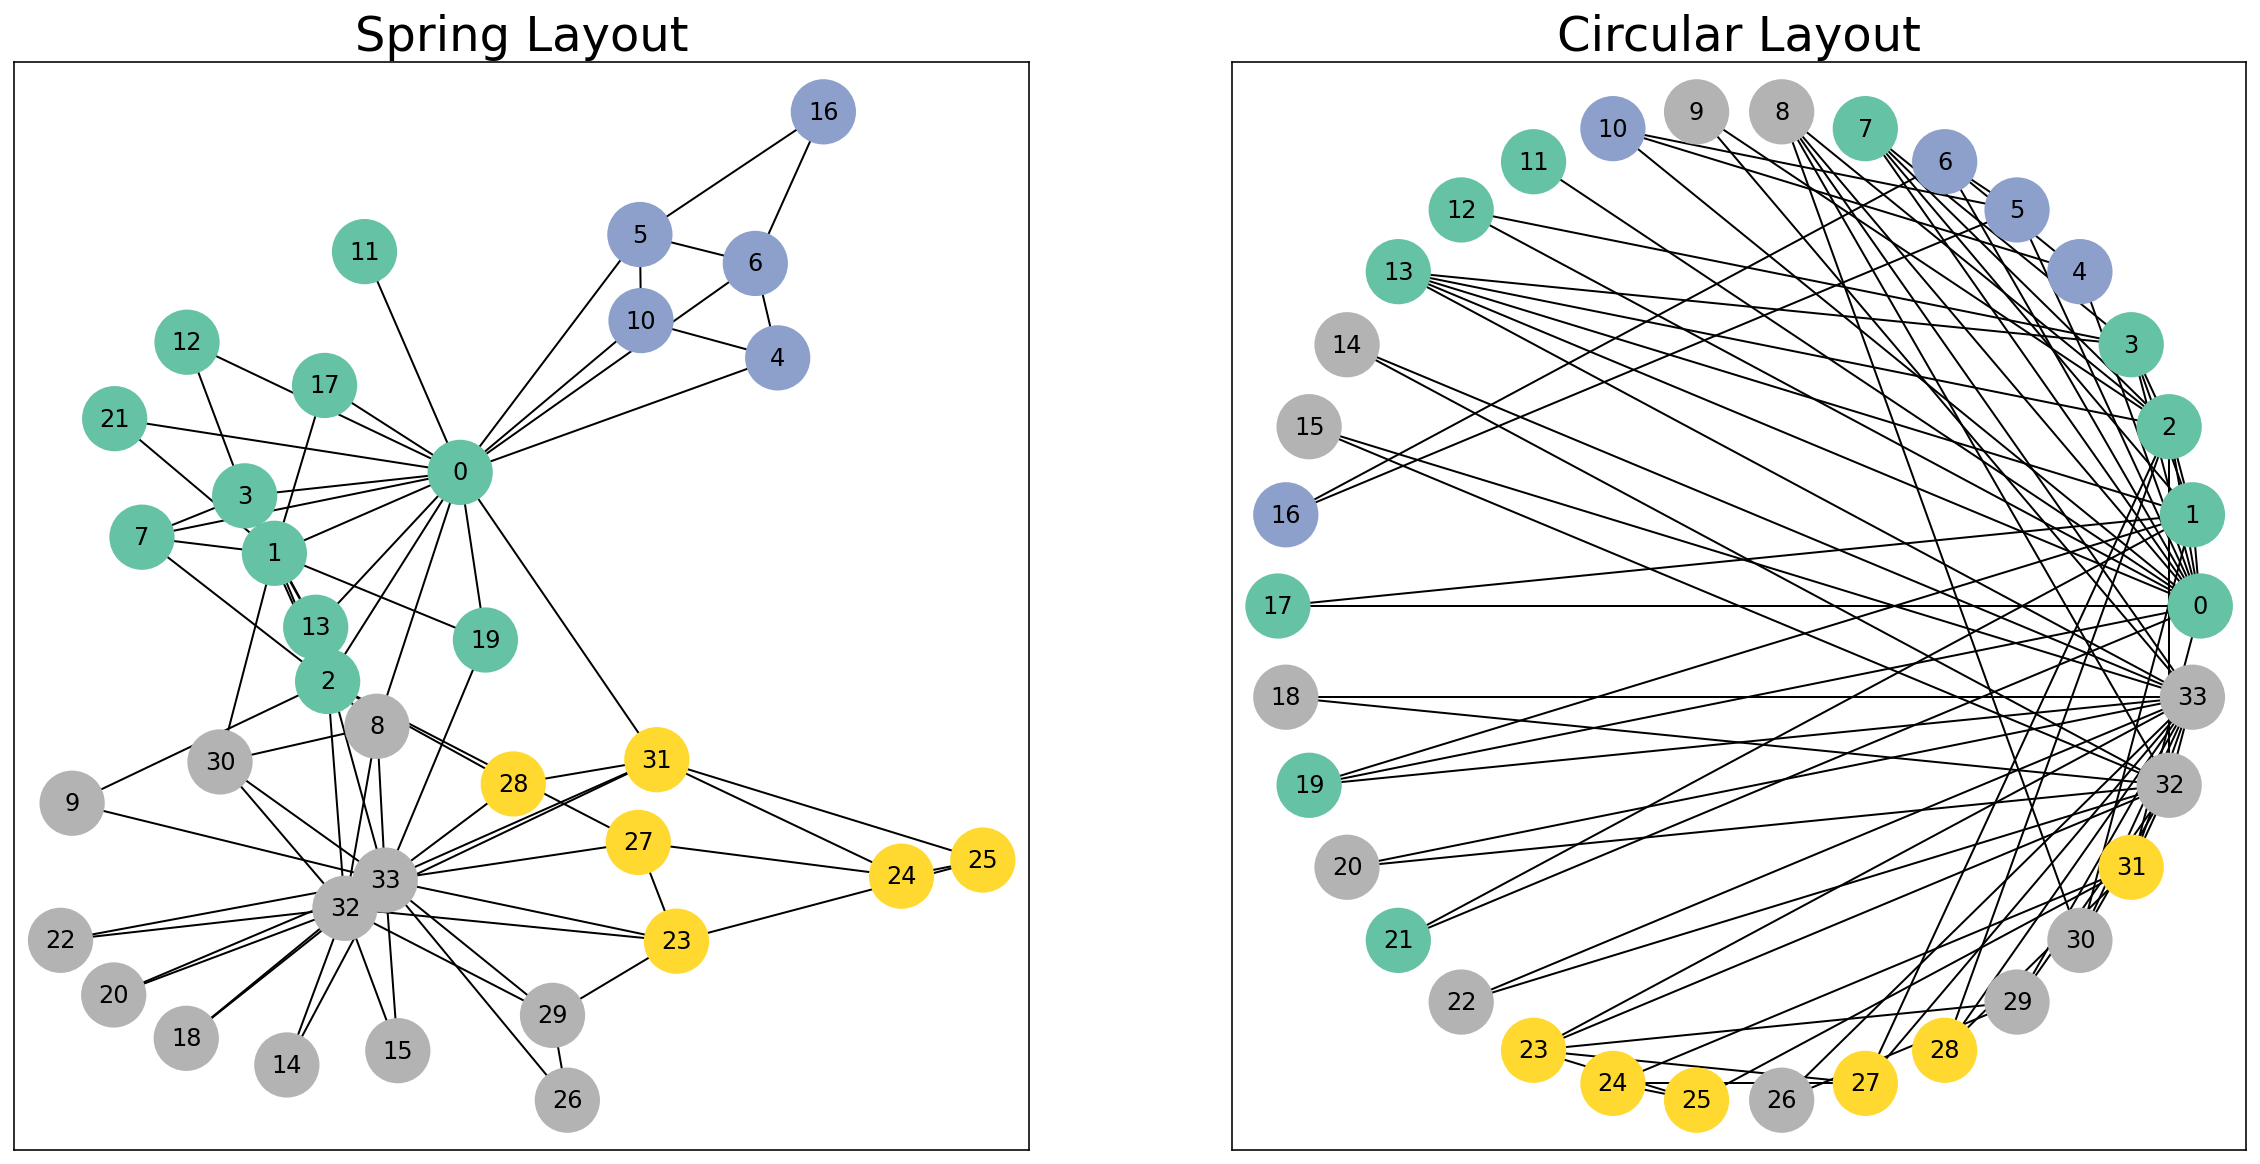

In [9]:
club_officer = []
fig, ax = plt.subplots(1,2,figsize=(20,10))
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), node_size=10**3, with_labels=True, node_color=data.y, cmap="Set2", ax=ax[0])
nx.draw_networkx(G, pos=nx.circular_layout(G), node_size=10**3, with_labels=True, node_color=data.y, cmap="Set2", ax=ax[1])

#handles, labels = ax[0].legend_elements()
#legend1 = ax[0].legend(handles, ['Class 1','Class 2', 'Class 3', 'Class 4'], loc="best", title="Classes")
#ax.add_artist(legend1);
#ax[0].legend()
ax[0].set_title('Spring Layout')
ax[1].set_title('Circular Layout');

Each node in the graph is a person. Every person has an associated number (index) and the club they would eventually join. In this form of visualization - node 0 and node 33 are Mr. Hi and Officer respectively. Besides that, each node has an associated edges with other nodes in the network based on connections (how exactly are those determined is not clear at first). Now having that connection we can construct an adjacency matrix. The environment of each node can be used to predict the final community the user would end up in. 

We can re-express this problem as given the nodes and the connections which club would each node join. We can see if the GCN network can predict the targets properly or rather if the targets can be used to find low dimensional embeddings for the graph objects such that each node is expressed in 2D. 

Each member of the community is described with a simple one-hot vector which in this case is a unitary matrix

In [10]:
target_classes = data.y.numpy()
unique, counts = np.unique(target_classes, return_counts=True)
dict(zip(unique, counts))

{0: 11, 1: 5, 2: 6, 3: 12}

TypeError: object of type 'ListedColormap' has no len()

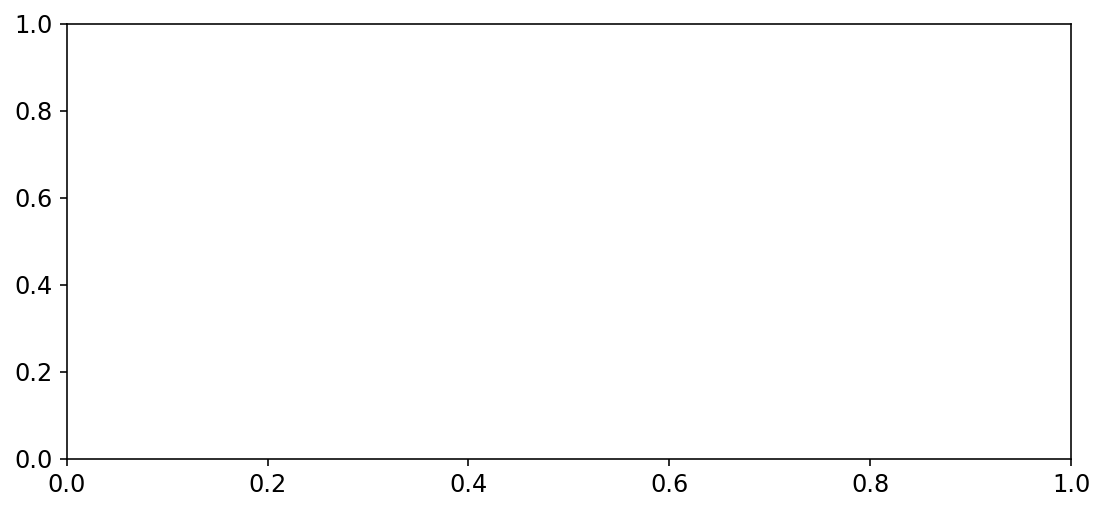

In [51]:
import seaborn as sns 
fig, ax = plt.subplots(1,1, figsize=(9,4))
ax.bar(unique, counts, tick_label=['Class 1','Class 2', 'Class 3', 'Class 4'], color=cm.Set2)

To describe each members in the network a one-hot encoding is used where the entry corresponding to the index of the node is 1 and everything else is 0. Sorting these nodes based on index we get a identity matrix (34, 34)

In [12]:
node_features = data.x

In [13]:
node_features

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

Next, every node in the graph is attached to other nodes. This information is stored in adjacency matrix. Self-connections are by default labelled 0. Every row of the adjacency matrix shows node connections

In [14]:
Karate_adjacency = torch.Tensor(nx.to_numpy_matrix(G))

In [15]:
Karate_adjacency

tensor([[0., 1., 1.,  ..., 1., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 1., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 1.,  ..., 1., 0., 1.],
        [0., 0., 0.,  ..., 1., 1., 0.]])

For example: as shown figure at the top if we look at node (16) it is connected to node (5,6) only. Hence in the adjacency matrix those index are 1 other that all other entries are 0

In [16]:
np.where( Karate_adjacency[16] == 1 )[0]

array([5, 6])

In [17]:
class GCNConv(nn.Module):
    def __init__(self, A, input_dims, output_dims):
        super(GCNConv, self).__init__()
        '''
        As per Tipf explanation: 
        https://tkipf.github.io/graph-convolutional-networks/
        https://arxiv.org/abs/1609.02907
        
        PARAMETERS: 
        ---------------
        A: numpy.array, Adjacency matrix for the graph object 
        input_dims: int, Input dimensions for the NN params
        output_dims: int, Output dimensions for the NN params 
        
        RETURNS: 
        ---------------
        out: torch.Tensor, N x output for the NN prediction
        '''
        torch.manual_seed(42)
        
        self.A_hat = A + torch.eye(A.size(0))
        self.D     = torch.diag(torch.sum(A,1)) #Diagonal node-degree matrix 
        self.D     = self.D.inverse().sqrt()
        self.A_hat = torch.mm( torch.mm(self.D, self.A_hat), self.D )
        self.W     = nn.Parameter(torch.rand(input_dims, output_dims, requires_grad=True))
    
    def forward(self, X):
        out = torch.tanh(torch.mm( torch.mm(self.A_hat, X), self.W ))
        
        return out

In [18]:
class Net(torch.nn.Module):
    def __init__(self, A, nfeat, nhid, c):
        super(Net, self).__init__()
        self.conv1 = GCNConv(A, nfeat, nhid)
        self.conv2 = GCNConv(A, nhid, nhid)
        self.conv3 = GCNConv(A, nhid, 2)
        self.linear = nn.Linear(2, nhid)
        
    def forward(self,X):
        H0  = self.conv1(X)
        H1 = self.conv2(H0)
        H2 = self.conv3(H1)
        out = self.linear(H2)
        
        return H2, out 

## ## Input vector for representing each node 

In [19]:
simple_GCN = Net(Karate_adjacency, node_features.size(0), 4, 4)

In [20]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam( simple_GCN.parameters(), lr=0.01 )

In [21]:
embeddings, out = simple_GCN(node_features)

In [22]:
loss=criterion( out[data.train_mask], data.y[data.train_mask] )
#loss=criterion( out, data.y )

In [23]:
loss

tensor(1.4069, grad_fn=<NllLossBackward>)

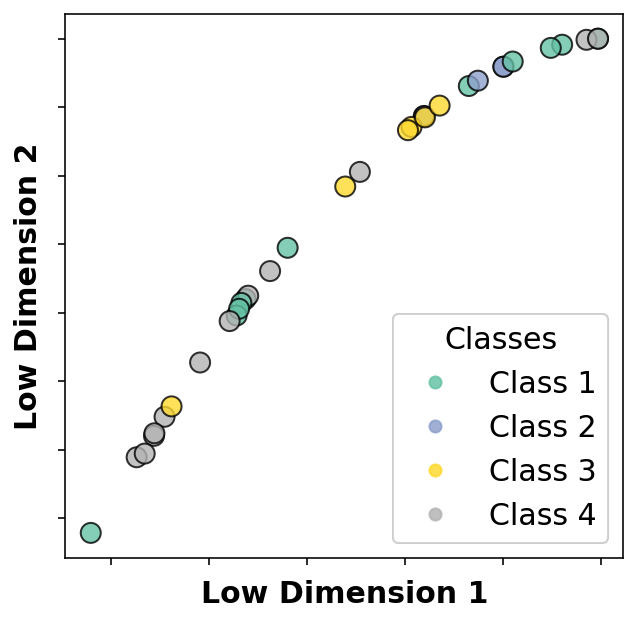

In [24]:
embeddings, _ = simple_GCN(node_features)
visualize_graph(data, embeddings)

The embeddings from the randomized initialization do not correspond to any clustering -- the red and grey points belong to 2 classes used in the dataset. Every node is condensed in two 2 dimensions here 

## ## Training the network to find low dimensional embeddings 

Step: 0 Cross Entropy Loss = 1.4068517684936523
Step: 1000 Cross Entropy Loss = 0.007039532531052828
Step: 2000 Cross Entropy Loss = 0.002065208973363042
Step: 3000 Cross Entropy Loss = 0.0009143914794549346
Step: 4000 Cross Entropy Loss = 0.00047073548194020987


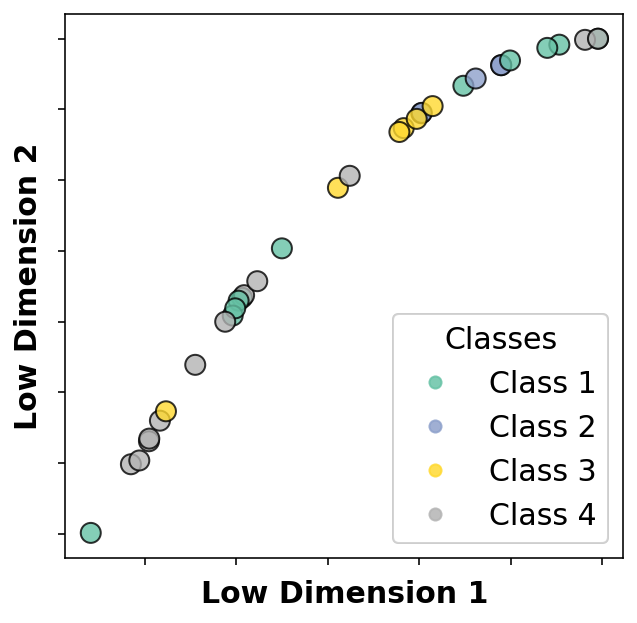

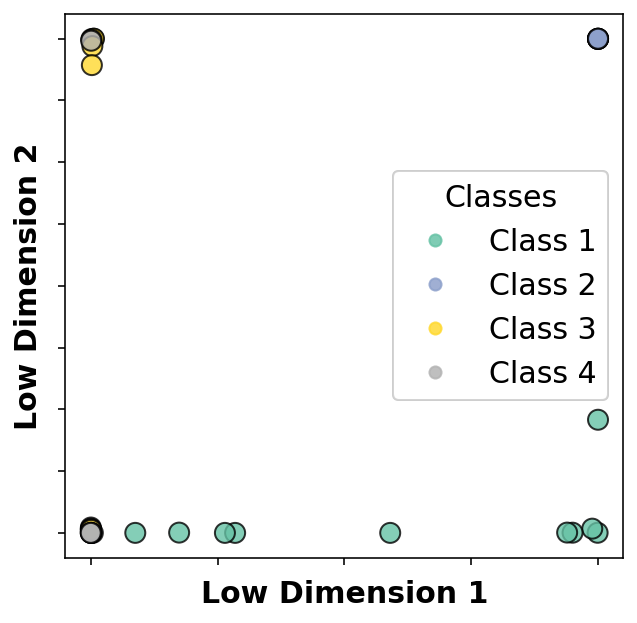

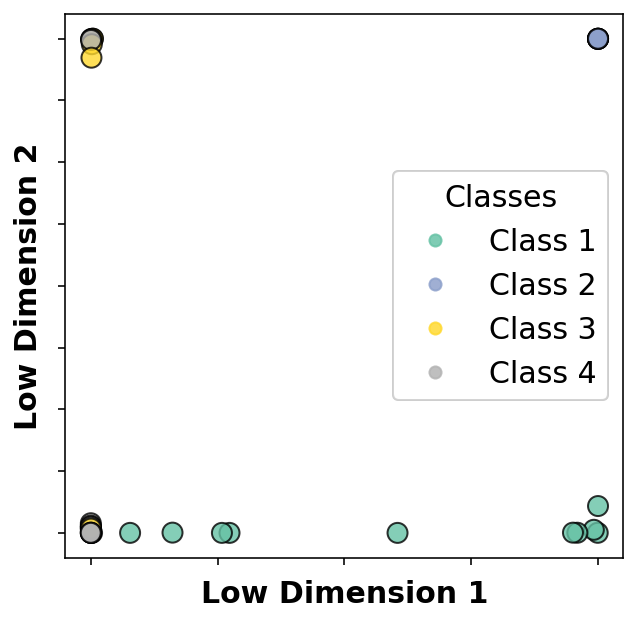

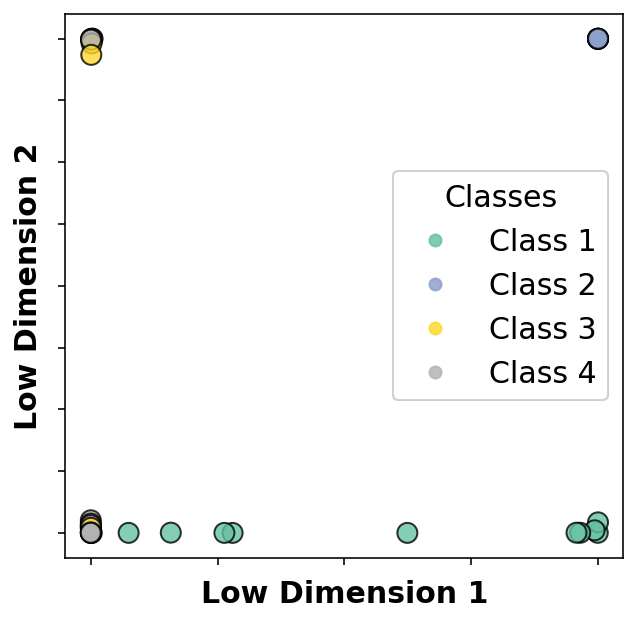

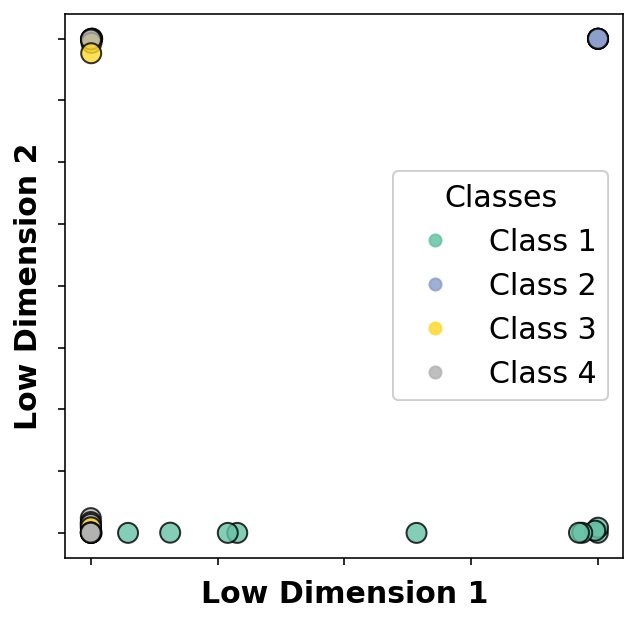

In [25]:
for i in range(5000):
    e, out = simple_GCN(node_features)
    optimizer.zero_grad()
    loss=criterion(out[data.train_mask], data.y[data.train_mask])
    #loss=criterion(out, data.y)
    loss.backward()
    optimizer.step()
    if i % 1000==0:
        print("Step: {} Cross Entropy Loss = {}".format(i, loss.item()))
        output_, _ = simple_GCN(node_features)
        visualize_graph(data, output_)

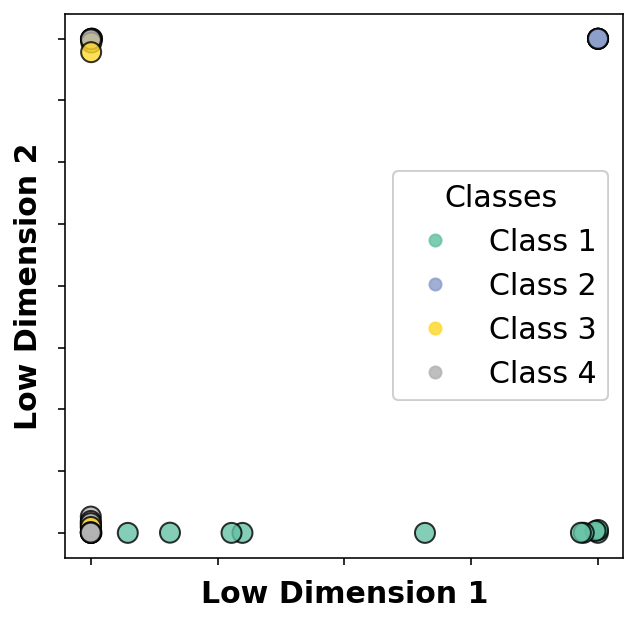

In [26]:
output_, _ = simple_GCN(node_features)
visualize_graph(data, output_)

The low dimensional embeddings learned from the target properties of the node are able to cluster into. Now this is useful as we can condense the high-dimensional graph network into 2D and label them as per the target and see the clustering. 

## ## Using PyTorch Geometric

In [27]:
from torch_geometric.nn import GCNConv
from torch_geometric.utils import add_self_loops, degree

In [28]:
class GCN(torch.nn.Module):
    def __init__(self, graph_data):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.graph_data = graph_data
        self.conv1 = GCNConv(self.graph_data.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = nn.Linear(2, self.graph_data.num_classes)

    def forward(self, node_features, edge_index):
        h = self.conv1(node_features, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

In [29]:
dataset.num_classes

4

In [30]:
model = GCN(dataset)
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


In [31]:
_, h = model(node_features, data.edge_index)
h = h.detach().numpy()
print(f'Embedding shape: {list(h.shape)}')

Embedding shape: [34, 2]


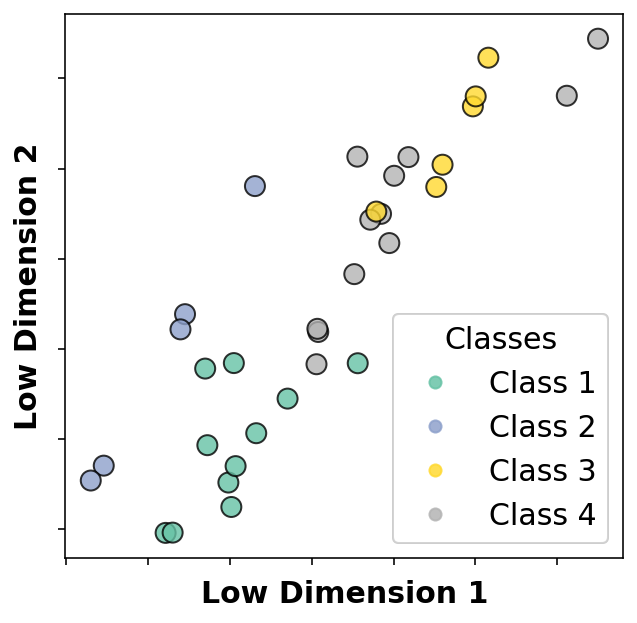

In [32]:
pyg_output_, _ = model(node_features, data.edge_index)
visualize_graph(data, pyg_output_)

Step: 0 Cross Entropy Loss = 1.415920615196228
Step: 100 Cross Entropy Loss = 0.2399735152721405
Step: 200 Cross Entropy Loss = 0.07003707438707352
Step: 300 Cross Entropy Loss = 0.038512904196977615
Step: 400 Cross Entropy Loss = 0.025275712832808495
Step: 500 Cross Entropy Loss = 0.018149543553590775
Step: 600 Cross Entropy Loss = 0.013782674446702003
Step: 700 Cross Entropy Loss = 0.010877968743443489
Step: 800 Cross Entropy Loss = 0.008831651881337166
Step: 900 Cross Entropy Loss = 0.0073273200541734695


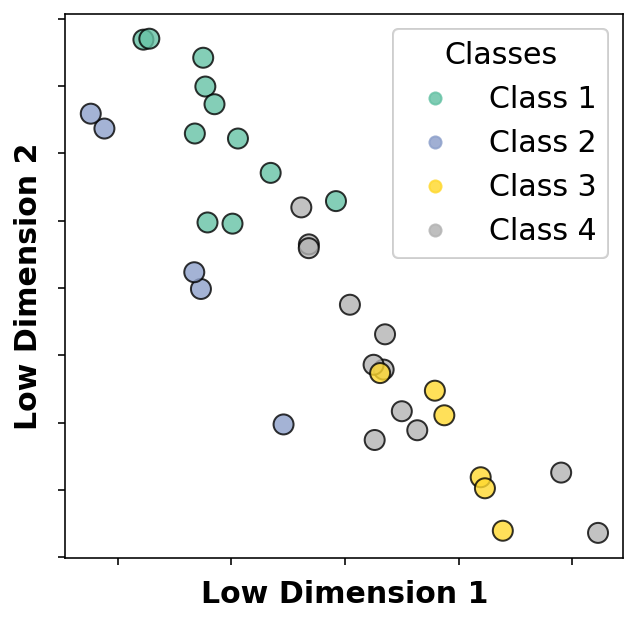

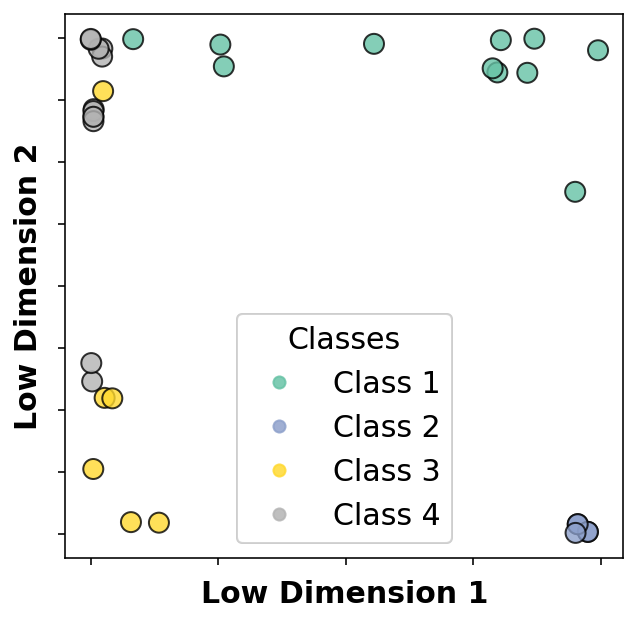

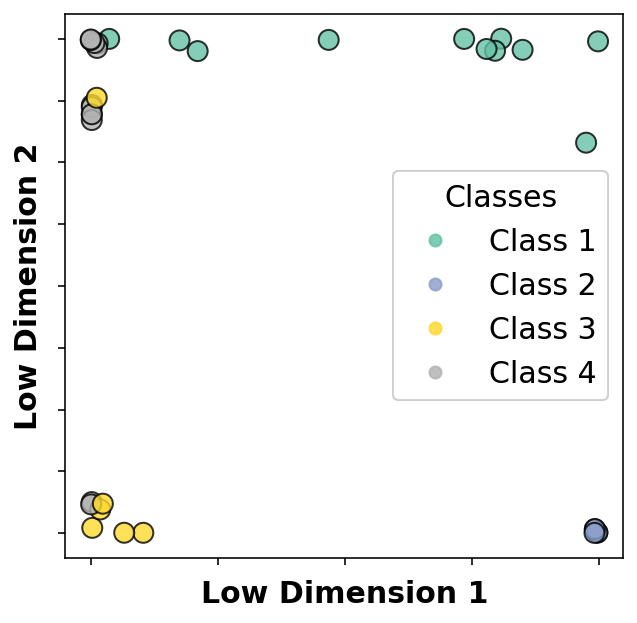

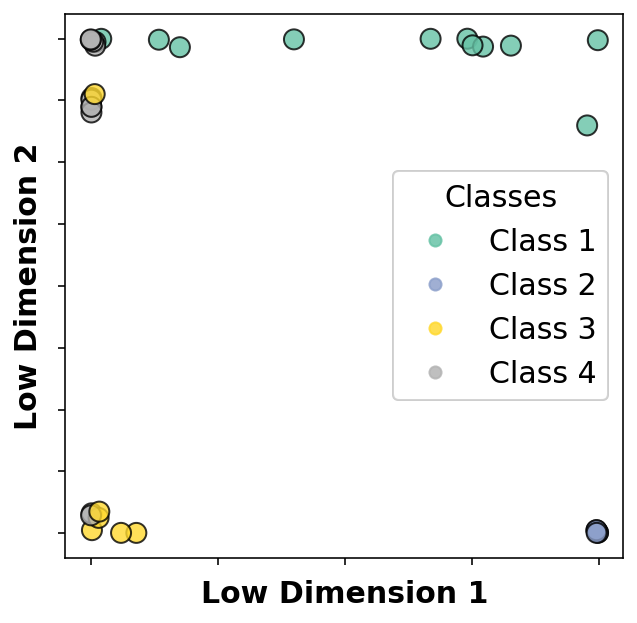

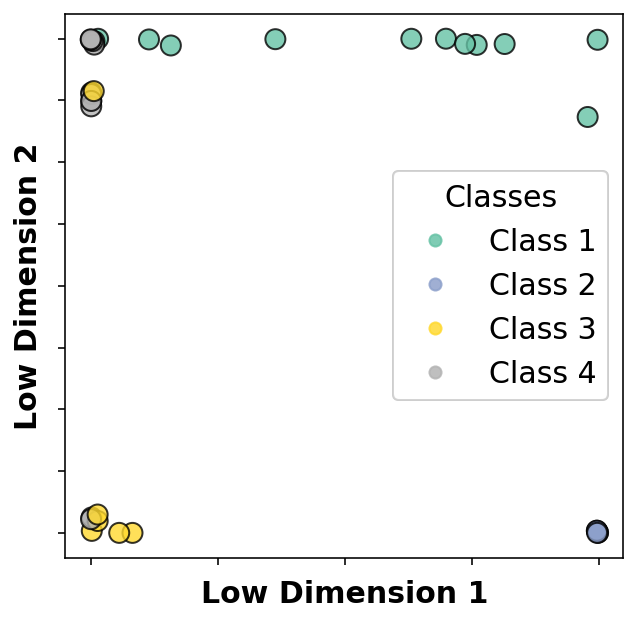

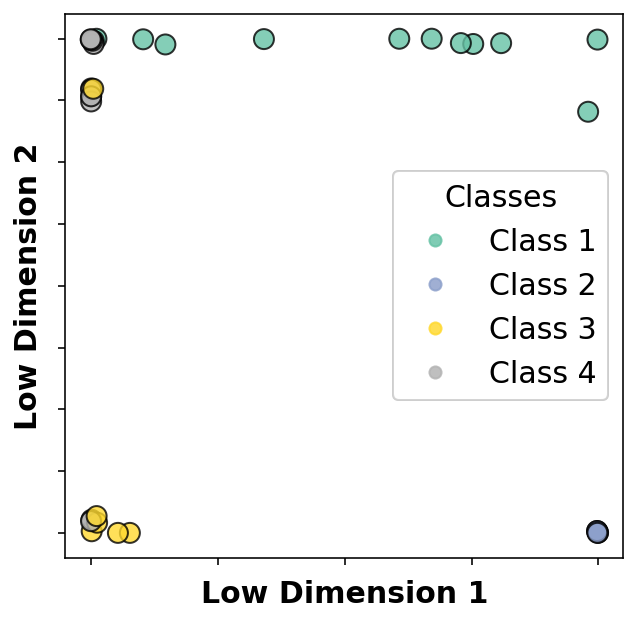

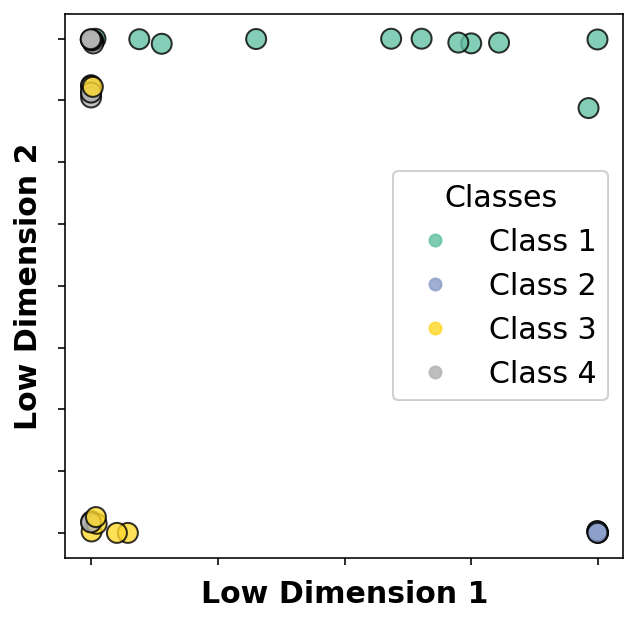

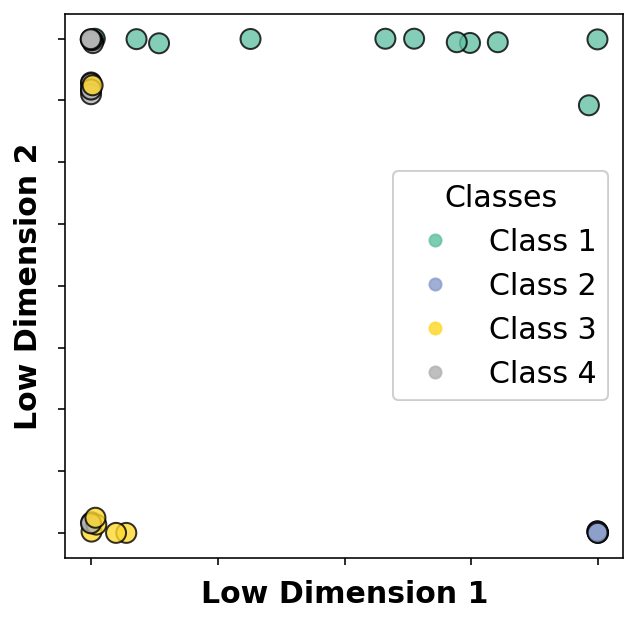

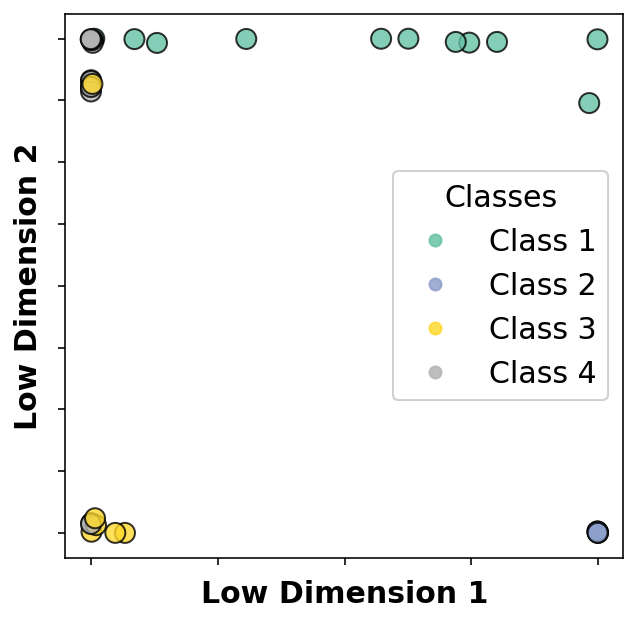

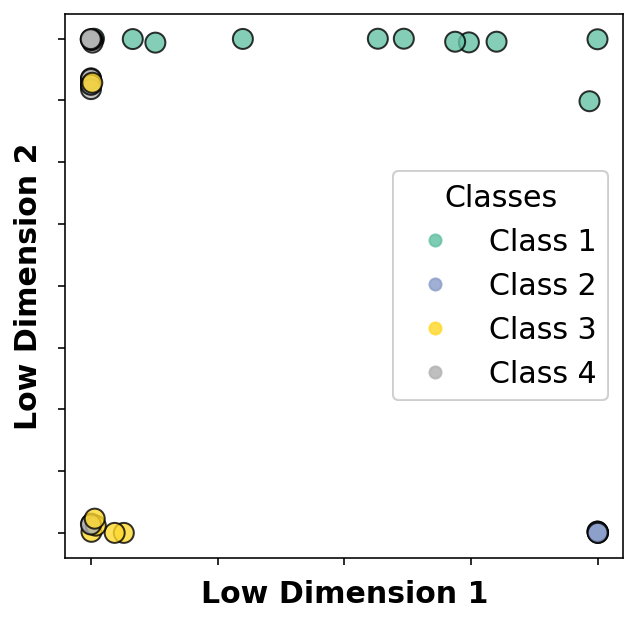

In [33]:
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(node_features, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(1000):
    loss, h = train(data)
    #if epoch % 10 == 0:
    #    visualize(h, color=data.y, epoch=epoch, loss=loss)
    #    time.sleep(0.3)
        
    if epoch % 100 == 0:
        print("Step: {} Cross Entropy Loss = {}".format(epoch, loss.item()))
        visualize_graph(data, h)